In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
# jupyter lab --NotebookApp.iopub_data_rate_limit=1.0e20
import warnings
warnings.filterwarnings('ignore')

## Load data

In [94]:
from pathlib import Path

import matplotlib.pylab as plt
import numpy as np
import pytorch_lightning as pl
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchinfo import summary
from pytorch_lightning.loggers import TensorBoardLogger

from lstm_model_behavior import RecurrentAutoencoder

In [3]:
PATH_ROOT = Path('/Volumes/GoogleDrive/My Drive/NMA-22/naturalistic_arm_movements_ecog')
PATH_DATA = PATH_ROOT / 'data' / 'behavior_data'
SEED = 42

DTYPE = torch.float
DEVICE = torch.device("mps")

In [4]:
dataset_full = np.load(PATH_DATA / "reaches.npy")
k_mean_labels = np.load(PATH_DATA / "k_mean_labels.npy")
dataset_full.shape

(5984, 2, 75)

## Prepare data

In [5]:
dataset = dataset_full.reshape((dataset_full.shape[0], dataset_full.shape[2], dataset_full.shape[1]))
# X_train, X_test = train_test_split(dataset_full[k_mean_labels == 2], test_size=0.04, random_state=SEED)
# X_train, X_test = train_test_split(dataset_full, test_size=0.04, random_state=SEED)
X_train, X_test = train_test_split(
    dataset_full[(k_mean_labels == 2) | (k_mean_labels == 8) | 
                 (k_mean_labels == 6) | (k_mean_labels == 0) ], test_size=0.04, random_state=SEED)

X_train, X_val = train_test_split(X_train, test_size=0.33, random_state=SEED)

X_train = torch.tensor(X_train, device=DEVICE, dtype=DTYPE)
X_test = torch.tensor(X_test, device=DEVICE, dtype=DTYPE)
X_val = torch.tensor(X_val, device=DEVICE, dtype=DTYPE)

# train_data = TensorDataset(X_train)
# test_data = TensorDataset(X_test)
X_train.shape

torch.Size([1210, 2, 75])

## Load model

In [90]:
rae_test = RecurrentAutoencoder(75, 2, 16)
summary(rae_test, (1, 75, 2),
        col_names=["input_size", "output_size", "num_params",
                  ]) # "kernel_size", "mult_adds", "trainable"]

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
RecurrentAutoencoder                     [1, 75, 2]                [1, 75, 2]                --
├─Encoder: 1-1                           [1, 75, 2]                [1, 16]                   --
│    └─LSTM: 2-1                         [1, 75, 2]                [1, 75, 32]               4,608
│    └─LSTM: 2-2                         [1, 75, 32]               [1, 75, 16]               3,200
├─Decoder: 1-2                           [1, 16]                   [1, 75, 2]                --
│    └─LSTM: 2-3                         [1, 75, 16]               [1, 75, 16]               2,176
│    └─LSTM: 2-4                         [1, 75, 16]               [1, 75, 32]               6,400
│    └─Linear: 2-5                       [1, 75, 32]               [1, 75, 2]                66
Total params: 16,450
Trainable params: 16,450
Non-trainable params: 0
Total mult-adds (M): 1.23
Input size (MB): 0.00
F

## Train model

In [95]:
#@title Init model
pl.seed_everything(42)
_, n_times, n_features = X_train.shape
K = 16
n_layers = 2

# Initialize model and Trainer
rae = RecurrentAutoencoder(n_times, n_features, K, n_layers)
pl.utilities.model_summary.summarize(rae, max_depth=-1)

Global seed set to 42


  | Name                 | Type    | Params
-------------------------------------------------
0 | encoder              | Encoder | 25.6 K
1 | encoder.rnn1         | LSTM    | 22.4 K
2 | encoder.rnn2         | LSTM    | 3.2 K 
3 | decoder              | Decoder | 19.5 K
4 | decoder.rnn1         | LSTM    | 2.2 K 
5 | decoder.rnn2         | LSTM    | 14.8 K
6 | decoder.output_layer | Linear  | 2.5 K 
-------------------------------------------------
45.1 K    Trainable params
0         Non-trainable params
45.1 K    Total params
0.180     Total estimated model params size (MB)

In [ ]:
n_epochs = 30
batch_size = 1

logger = TensorBoardLogger(
    "tb_logs",
    name=f"K_{K}_lr_{rae.lr}_bs_{batch_size}_nl_{n_layers}_grad_acc_T_LR_sch_T_custom_loss_classes_0_2_6_8")


trainer = pl.Trainer(
    max_epochs=n_epochs, 
    accelerator='mps', 
    logger=logger,
    accumulate_grad_batches={0: 8, 4: 4, 8: 1})

# Perform training
trainer.fit(rae,
            DataLoader(
                X_train,
                batch_size=batch_size,
                shuffle=True),
            DataLoader(
                X_val,
                batch_size=batch_size,
                shuffle=False),
            )

# Perform evaluation
trainer.test(rae, DataLoader(
    X_test,  # mock_data,
    shuffle=False))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 25.6 K
1 | decoder | Decoder | 19.5 K
------------------------------------
45.1 K    Trainable params
0         Non-trainable params
45.1 K    Total params
0.180     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



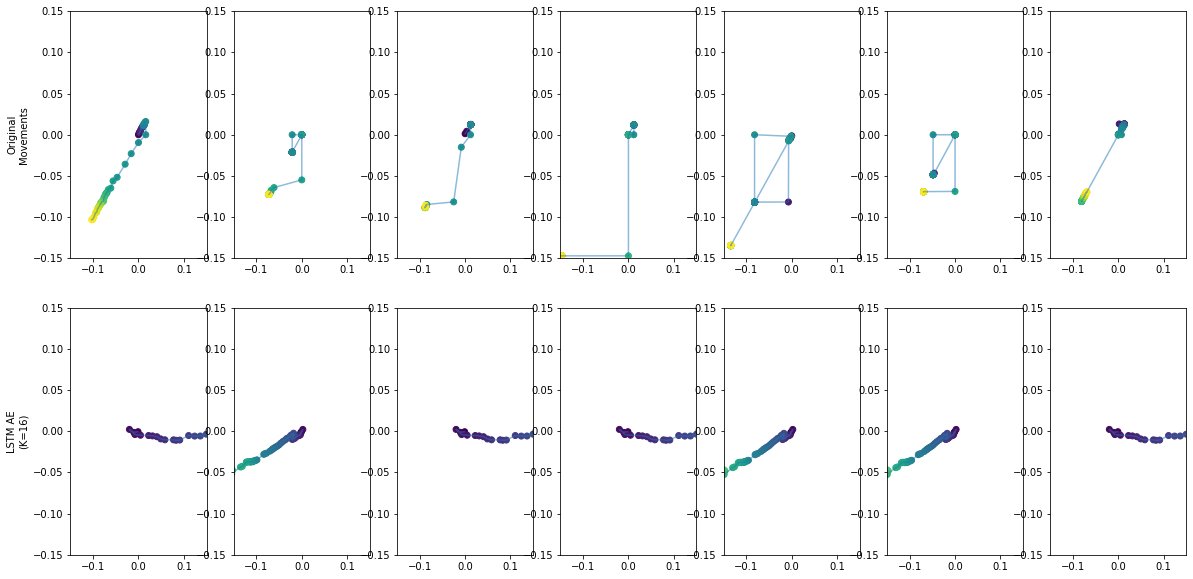

In [93]:
n_plot = 7
plt.figure(figsize=(20, 10))
# dataset_all = X_train.to('cpu')
dataset_all = torch.tensor(dataset[k_mean_labels == 8], device='cpu')

def plot_reaches_(x, y, duration=0):
    plt.plot(x, y, '-', alpha = 0.5)
    plt.scatter(x, y, c=np.arange(75))
    if duration != 0:
        plt.scatter(x[duration], y[duration], c = "r")
    plt.xlim(-0.15, 0.15)
    plt.ylim(-0.15, 0.15)

for i in range(n_plot):
    idx = torch.randint(len(dataset_all), size=())
    data_ = dataset_all[idx]
    with torch.no_grad():
      # Get reconstructed movements from autoencoder
      rae_recon = rae(data_.unsqueeze(0).to('cpu').float())[0]

    plt.subplot(2, n_plot, i+1)
    plot_reaches_(data_[:, 0], data_[:, 1])
    if i == 0:
        plt.ylabel('Original\nMovements')

    plt.subplot(2, n_plot, i + 1 + n_plot)
    plot_reaches_(rae_recon[0, :], rae_recon[1, :])
    if i == 0:
        plt.ylabel(f'LSTM AE\n(K={K})')
plt.show()

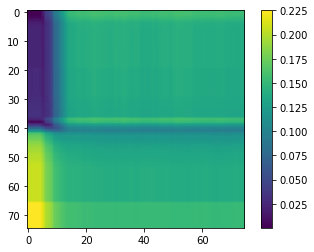

In [47]:
plt.imshow(torch.cdist(data_.double(), rae_recon.T.double()))
plt.colorbar()

In [37]:
torch.diff(rae_recon.T).max()

tensor(-0.0001)

In [49]:
rae_recon.T.shape

torch.Size([75, 2])

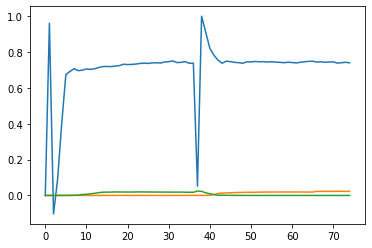

In [74]:
for (d1, d2) in zip(data_.unsqueeze(0), rae_recon.T.unsqueeze(0)):
    cs = torch.nn.functional.cosine_similarity(d1, d2)
l2 = torch.nn.functional.mse_loss(data_, rae_recon.T, reduction='none')
plt.plot(cs)
plt.plot(l2)

In [66]:
data_.unsqueeze(0).shape

torch.Size([1, 75, 2])

In [76]:
for (d1, d2) in zip(data_.unsqueeze(0), rae_recon.T.unsqueeze(0)):
    cs = torch.nn.functional.cosine_similarity(d1, d2).max()
    print(cs)

tensor(0.9990, dtype=torch.float64)


In [78]:
for (d1, d2) in zip(data_.unsqueeze(0), rae_recon.T.unsqueeze(0)):
    cs = torch.nn.functional.cosine_similarity(d1, d1).mean()
    print(cs)

tensor(0.9867, dtype=torch.float64)


In [83]:
torch.nn.functional.cosine_similarity(data_, -data_)

tensor([ 0.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000], dtype=torch.float64)

In [80]:
data_.shape

torch.Size([75, 2])

In [87]:
for (d1, d2) in zip(data_.unsqueeze(0), rae_recon.T.unsqueeze(0)):
    cs = torch.nn.functional.cosine_embedding_loss(d1, target=d2)
    print(cs)



TypeError: cosine_embedding_loss() missing 1 required positional argument: 'input2'

In [88]:
torch.nn.functional.cosine_embedding_loss?

Signature:
torch.nn.functional.cosine_embedding_loss(
    input1: torch.Tensor,
    input2: torch.Tensor,
    target: torch.Tensor,
    margin: float = 0,
    size_average: Union[bool, NoneType] = None,
    reduce: Union[bool, NoneType] = None,
    reduction: str = 'mean',
) -> torch.Tensor
Docstring:
cosine_embedding_loss(input1, input2, target, margin=0, size_average=None, reduce=None, reduction='mean') -> Tensor

See :class:`~torch.nn.CosineEmbeddingLoss` for details.
File:      /opt/anaconda3/envs/Neuromatch_2022_EcoG_movements/lib/python3.8/site-packages/torch/nn/functional.py
Type:      function
